# Semantic Video Search

In [90]:
import json
import boto3
from botocore.exceptions import ClientError
import os
import uuid
import time
import logging
import re
import io
from IPython.display import JSON
import subprocess
import matplotlib.pyplot as plt
from PIL import Image
import glob
import base64
import math
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

In [91]:
%store -r

In [92]:
%store

Stored variables and their in-db values:
sagemaker_resources             -> {'bucket': 'sagemaker-us-west-2-556443368529', 'ro
session                         -> {'bucket': 'sagemaker-us-west-2-556443368529', 'Me
video                           -> {'path': 'Netflix_Open_Content_Meridian.mp4', 'out


In [93]:
def start_transcription_job(
    job_name,
    media_uri,
    media_format,
    language_code,
    transcribe_client,
    output_bucket_name,
    vocabulary_name=None,
):
    """
    Starts a transcription job. This function returns as soon as the job is started.
    To get the current status of the job, call get_transcription_job. The job is
    successfully completed when the job status is 'COMPLETED'.

    :param job_name: The name of the transcription job. This must be unique for
                     your AWS account.
    :param media_uri: The URI where the audio file is stored. This is typically
                      in an Amazon S3 bucket.
    :param media_format: The format of the audio file. For example, mp3 or wav.
    :param language_code: The language code of the audio file.
                          For example, en-US or ja-JP
    :param transcribe_client: The Boto3 Transcribe client.
    :param vocabulary_name: The name of a custom vocabulary to use when transcribing
                            the audio file.
    :return: Data about the job.
    """
    job_args = {
        "TranscriptionJobName": job_name,
        "Media": {"MediaFileUri": media_uri},
        "MediaFormat": media_format,
        "LanguageCode": language_code,
        "Subtitles": {"Formats": ["srt"]},
        "OutputBucketName": output_bucket_name,
    }
    if vocabulary_name is not None:
        job_args["Settings"] = {"VocabularyName": vocabulary_name}
    response = transcribe_client.start_transcription_job(**job_args)
    job = response["TranscriptionJob"]
    return job

def wait_for_transcription_complete(transcribe_client, job_id):
    response = transcribe_client.get_transcription_job(
        TranscriptionJobName=job_id
    )
    while True:
        job_status = response['TranscriptionJob']['TranscriptionJobStatus']
        print(f"job_status: {job_status}")
        if job_status in ('FAILED', 'COMPLETED'):
            break
        time.sleep(5)
        response = transcribe_client.get_transcription_job(
            TranscriptionJobName=job_id
        )

def start_rekognition_segment_detection(rek_client,
                                        bucket_videos, 
                                        video_name, 
                                        min_Shot_Confidence=80.0):

    response = rek_client.start_segment_detection(
        Video={"S3Object": {"Bucket": bucket_videos, "Name": video_name}},
        SegmentTypes=["SHOT"],
        Filters={
            "ShotFilter": {"MinSegmentConfidence": min_Shot_Confidence},
        },
    )

    startJobId = response["JobId"]
    return startJobId

def wait_for_rekognition_segment_detection_complete(rek_client, job_id):
    response = rek_client.get_segment_detection(JobId=job_id)
    while True:
        job_status = response["JobStatus"]
        print(f"job_status: {job_status}")
        if job_status in ['SUCCEEDED', 'FAILED']:
            break
        time.sleep(5)
        response = rek_client.get_segment_detection(JobId=job_id)
    return response

First we want to download some video assets and process them. These assets are stored in an S3 bucket publically for the workshop.


In [103]:
video_name = "Netflix_Open_Content_Meridian_5m.mp4"

In [105]:
!ffmpeg -ss 00:0:30 -to 00:5:30 -i Netflix_Open_Content_Meridian.mp4 -c copy $video_name -y

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [107]:
# !wget --no-check-certificate https://ws-assets-prod-iad-r-pdx-f3b3f9f1a7d6a3d0.s3.us-west-2.amazonaws.com/7db2455e-0fa6-4f6d-9973-84daccd6421f/$video_name

Upload the assets to an S3 bucket in the same AWS account so that we could invoke API to process them.

In [108]:
bucket_videos = session["bucket"]
bucket_transcripts = session["bucket"]
bucket_images = session["bucket"]
bucket_shots = session["bucket"]

In [109]:
!aws s3 cp $video_name s3://$bucket_videos/

upload: ./Netflix_Open_Content_Meridian_5m.mp4 to s3://sagemaker-us-west-2-556443368529/Netflix_Open_Content_Meridian_5m.mp4


First, start a transcription job to extract the audio text from the video

## Step 1: Start a Transcription Job
We are going to use [Amazon Transcribe](https://docs.aws.amazon.com/transcribe/latest/dg/what-is.html) to extracrt the audio text from the video. Amazon Transcribe is an automatic speech recognition service that uses machine learning models to convert audio to text. You can use Amazon Transcribe as a standalone transcription service or to add speech-to-text capabilities to any application.

With Amazon Transcribe, you can improve accuracy for your specific use case with language customization, filter content to ensure customer privacy or audience-appropriate language, analyze content in multi-channel audio, partition the speech of individual speakers, and more.

You can transcribe media in real time (streaming) or you can transcribe media files located in an Amazon S3 bucket (batch). 


Initialze AWS SDK clients

In [110]:
transcribe_client = boto3.client("transcribe")

In [111]:
transcribe_jobs = []
jobId = uuid.uuid4().hex # this could be a unique identifier that you can pass throughout the session 
job = start_transcription_job(
        jobId,
        "s3://" + bucket_videos + "/" + video_name,
        "mp4",
        "en-US",
        transcribe_client,
        bucket_transcripts,
        None,
    )
transcribe_jobs.append(jobId)

In [112]:
wait_for_transcription_complete(transcribe_client, jobId)

job_status: IN_PROGRESS
job_status: IN_PROGRESS
job_status: IN_PROGRESS
job_status: IN_PROGRESS
job_status: COMPLETED


## Step 2: Detect Video Segments

Initialze AWS SDK clients

In [113]:
rek_client = boto3.client("rekognition")

In [128]:
min_Shot_Confidence = 90.0

In [129]:
rek_job_id = start_rekognition_segment_detection(rek_client,
                                    bucket_videos, 
                                    video_name, 
                                    min_Shot_Confidence=min_Shot_Confidence)

Wait for the video sgement detection job to complete.

In [130]:
rek_shot_segment_response = wait_for_rekognition_segment_detection_complete(rek_client, rek_job_id)

job_status: IN_PROGRESS
job_status: IN_PROGRESS
job_status: IN_PROGRESS
job_status: IN_PROGRESS
job_status: IN_PROGRESS
job_status: IN_PROGRESS
job_status: IN_PROGRESS
job_status: SUCCEEDED


Processing the shot segments

In [131]:
def get_frames(shot, N): 
        '''
        Extracts N frames from the given shot. This step is performed to reduce the compute required to process a shot.
        Input: shot - shot object with images,
               N - number of images to extract from the shot
        Returns: extracted frames
        '''
        start_frame = shot["StartFrameNumber"]
        end_frame = (
            shot["EndFrameNumber"] - 1
        )  # frame - 1 to avoid bug not getting the last frame of the video
        step = (end_frame - start_frame) / (N - 1)
        frames = [int(start_frame + i * step) for i in range(N)]
        return frames

In [132]:
frames = []
shots  = []
delta = rek_shot_segment_response["Segments"][0]["StartTimestampMillis"]
frames_per_shot = 4 # number of frames to extract from a detected shot.
for shot in rek_shot_segment_response["Segments"]:
    shot_frames = get_frames(shot, frames_per_shot)
    frames.extend(shot_frames)
    # frames.append(shot["StartFrameNumber"])

    shot_startTime = shot["StartTimestampMillis"] - delta
    shot_endTime = shot["EndTimestampMillis"] - delta

    shots.append(
        {
            "jobId": jobId,
            "video_name": video_name,
            "shot_startTime": shot_startTime,
            "shot_endTime": shot_endTime,
            "frames": shot_frames,
        }
    )

In [168]:
rek_shot_segment_response["Segments"][1]

{'Type': 'SHOT',
 'StartTimestampMillis': 6072,
 'EndTimestampMillis': 15148,
 'DurationMillis': 9076,
 'StartTimecodeSMPTE': '00:00:05;04',
 'EndTimecodeSMPTE': '00:00:14;06',
 'DurationSMPTE': '00:00:09;02',
 'ShotSegment': {'Index': 1, 'Confidence': 99.9851303100586},
 'StartFrameNumber': 154,
 'EndFrameNumber': 426,
 'DurationFrames': 272}

Let's visualize the first 10 shots in JSON structure:

In [133]:
JSON(shots[:10])

<IPython.core.display.JSON object>

### Step 2.1: Generate Shot Images
Extract images based on the given frame indexes, then upload the frames to the given S3 bucket.

In [169]:
s3_client = boto3.client("s3")
tmp_dir = "/tmp"
tmp_video_dir = tmp_dir + "/video/"
tmp_frames_dir = tmp_dir + "/" + jobId + "/"
os.makedirs(tmp_video_dir, exist_ok=True)
os.makedirs(tmp_frames_dir, exist_ok=True)
ffmpeg_path = "/usr/bin/ffmpeg"
local_video_path = os.path.join(tmp_video_dir, video_name)

In [170]:
s3_client.download_file(bucket_videos, video_name, local_video_path)

verify that the files are downloaded

In [171]:
!ls -lrt $local_video_path

-rw-r--r-- 1 sagemaker-user users 23796242 Nov  5 00:53 /tmp/video/Netflix_Open_Content_Meridian_5m.mp4


Given the frame level information, in the following section, we are going to use [ffmpeg](https://www.ffmpeg.org/) to help us extract the corresponding images. 

In [172]:
frame_list = "+".join([f"eq(n,{frame})" for frame in frames])

In [173]:
output_pattern = f"{tmp_frames_dir}%d.png"
_ = subprocess.run(
    [
        ffmpeg_path,
        "-i",
        local_video_path,
        "-vf",
        f"select='{frame_list}'",
        "-vsync",
        "0",
        "-frame_pts",
        "1",
        output_pattern,
    ],
    stderr=subprocess.PIPE
)

Let's visualize the first 5 shots extracted from the shot segment job

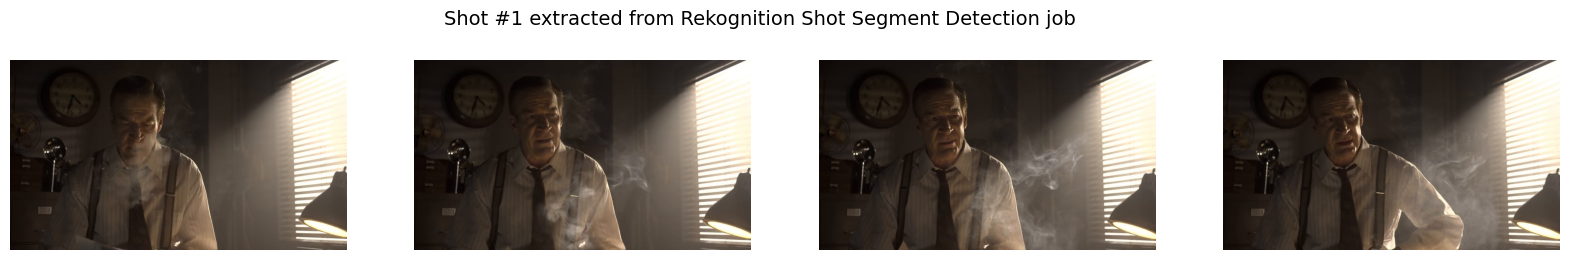

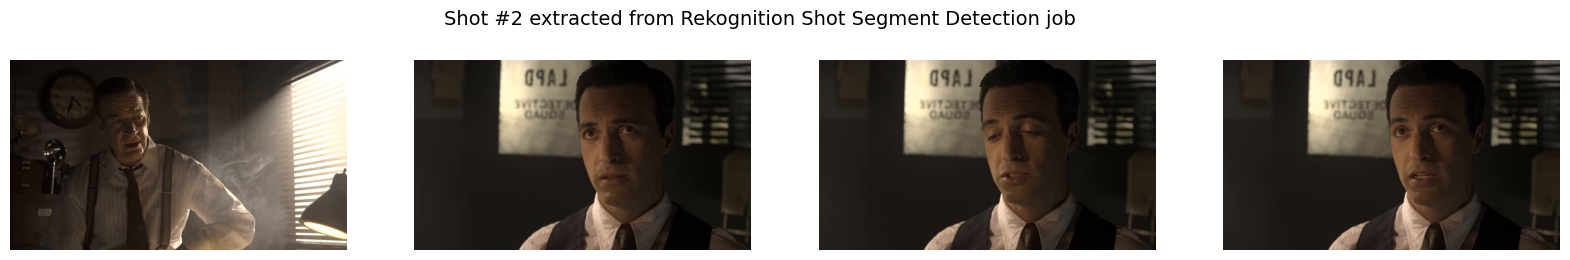

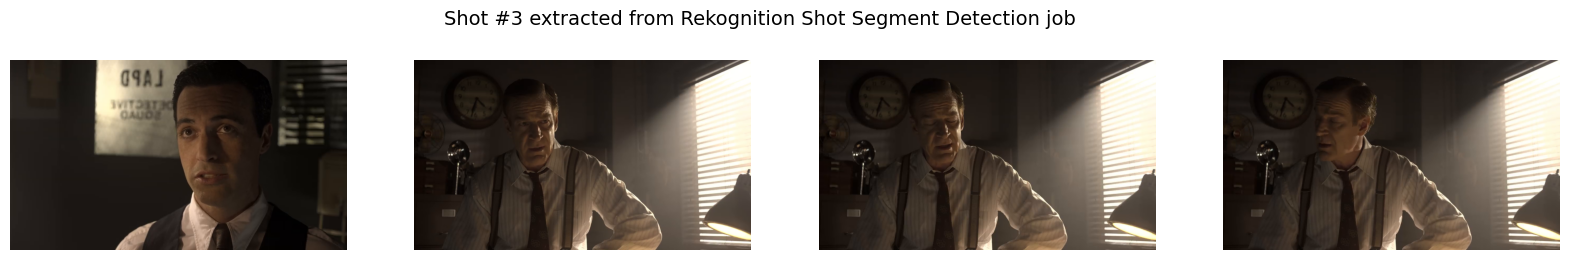

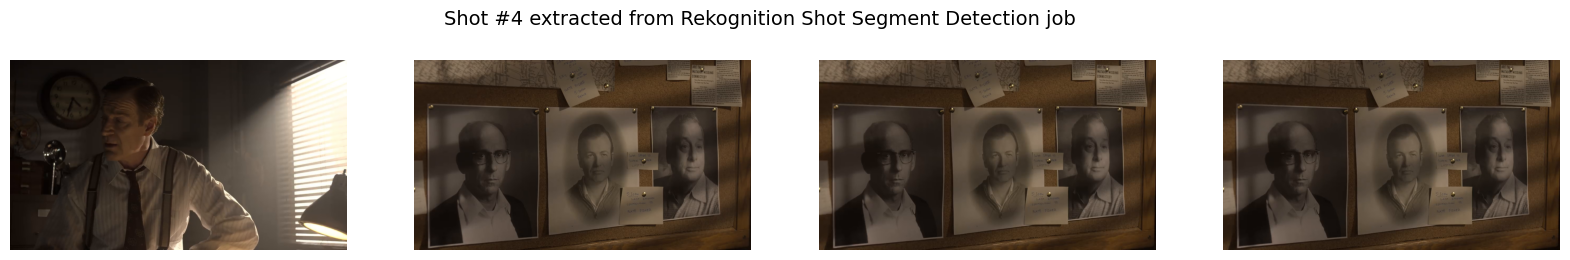

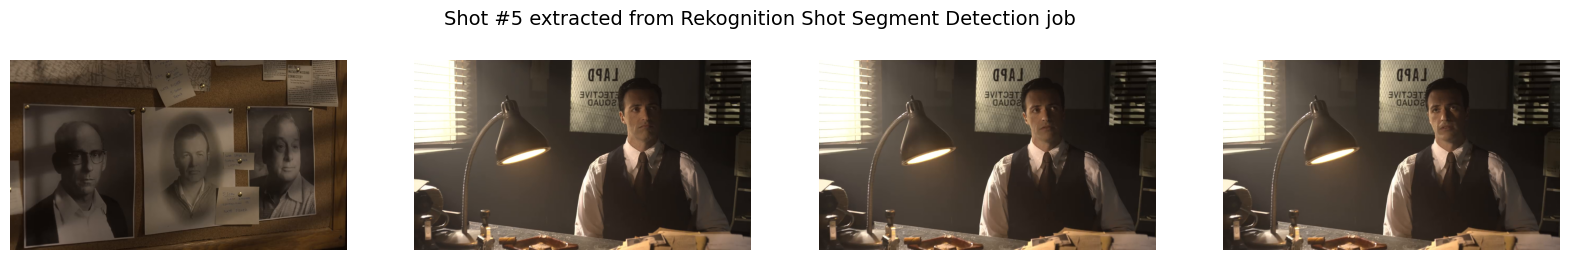

In [174]:
image_paths = glob.glob(f"{tmp_frames_dir}/*.png")

for shot_nbr in range(5):
    fig, axes = plt.subplots(1, frames_per_shot, figsize=(20, 3))
    fig.suptitle(f"Shot #{shot_nbr+1} extracted from Rekognition Shot Segment Detection job", fontsize=14)
    for i, ax in enumerate(axes.flat):
        img = Image.open(image_paths[i+(shot_nbr*frames_per_shot)])
        ax.imshow(img)
        ax.axis('off')
    plt.show()

Upload the image frames to S3 bucket for further processing

In [175]:
extra_args = {"ContentType": "image/png"}
for frame_file in os.listdir(tmp_frames_dir):
    frame_path = os.path.join(tmp_frames_dir, frame_file)
    s3_client.upload_file(
        frame_path, bucket_images, f"{jobId}/images/{frame_file}", ExtraArgs=extra_args
    )

In [176]:
def generate_shot_image(images, bucket_shots, shot_id, border_size=5):
    num_images = len(images)
    grid_size = math.ceil(math.sqrt(num_images))
    grid_width = grid_size * images[0].width
    grid_height = grid_size * images[0].height
    grid_image = Image.new("RGB", (grid_width, grid_height))

    ## Horizontal grid ###
    grid_width = sum(image.width + border_size for image in images) - border_size
    grid_height = max(image.height for image in images)
    grid_image = Image.new("RGB", (grid_width, grid_height))
    x_offset = 0
    for image in images:
        grid_image.paste(image, (x_offset, 0))
        x_offset += image.width + border_size

    with io.BytesIO() as buffer:
        grid_image.save(buffer, format="PNG")
        buffer.seek(0)
        image_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
        s3_client.upload_fileobj(
            buffer,
            bucket_shots,
            f"{jobId}/shots/{shot_id}.png",
            ExtraArgs={"ContentType": "image/png"},
        )

In [177]:
s3_client = boto3.client("s3")

In [178]:
import multiprocessing

def process_shot(shot):
    frames = shot['frames']
    shot_startTime = shot['shot_startTime']
    shot_endTime = shot['shot_endTime']
    jobId = shot['jobId']
    images = []
    shot_id = f"{shot_startTime}-{shot_endTime}"
    for frame in frames:
        frame_path = os.path.join(tmp_frames_dir, f"{frame}.png")
        images.append(Image.open(frame_path))
    generate_shot_image(images, bucket_shots, shot_id)
    return shot_id

In [179]:
multi_processing_shots = [ (x, ) for x in shots ]

In [180]:
with multiprocessing.Pool() as pool:
    shot_ids = pool.starmap(process_shot, multi_processing_shots)

Let's visualize a few shot images generated in the previous step to give us an idea of what they look like

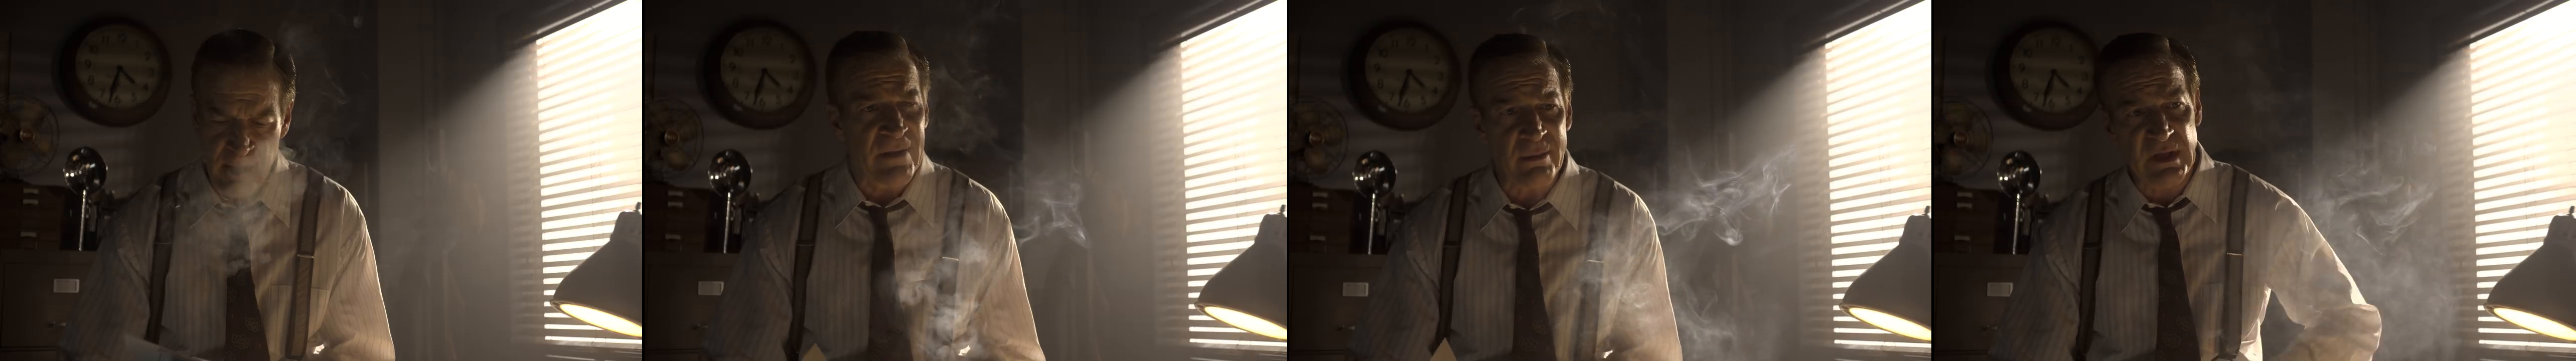

In [181]:
shot_id_sample = shot_ids[0]
shot_id_sample_image = s3_client.get_object(Bucket=bucket_images, Key=f"{jobId}/shots/{shot_id_sample}.png")
image_data = shot_id_sample_image["Body"].read()
image = Image.open(io.BytesIO(image_data))

# Display the image
image.show()

### Step 3: Celebrity Detection
In addition to segment detection above, [Amazon Rekognition](https://aws.amazon.com/rekognition/) can also be used to recognize international, widely known celebrities like actors, sportspeople, and online content creators. The metadata provided by the celebrity recognition API significantly reduces the repetitive manual effort required to tag content and make it readily searchable. 
In the following section, we'll leverage this feature to help us detect any celebrities in the images extracted in the previous step.

In [182]:
def celebrity_detection(shot):
    """
    Invokes Amazon Rekognition API for celebrity Detection.
    Filter the celebrities by the confident score. 
    Input: shot level information
    Output: detected celebrity and associated objects
    """
    shot_frames_public_figures = []
    frames = shot["frames"]
    for frame in frames:
        object_key = f"{jobId}/images/{frame}.png"
        response = rek_client.recognize_celebrities(
            Image={
                "S3Object": {"Bucket": bucket_images, "Name": object_key}
            }
        )
        celebrities = set()
        min_confidence = 80.0 # change this value if the accuracy is low.

        for celebrity in response.get("CelebrityFaces", []):
            if celebrity.get("MatchConfidence", 0.0) >= min_confidence:
                celebrities.add(celebrity["Name"])
        celebrities = ", ".join(celebrities)
        shot_frames_public_figures.append({"frame": frame, "frame_publicFigures": celebrities})
    return shot_frames_public_figures

In [183]:
multi_processing_shots = [ (x, ) for x in shots ]

In [184]:
with multiprocessing.Pool() as pool:
    shot_frames_public_figures = pool.starmap(celebrity_detection, multi_processing_shots)

Let's take a look into the celebrity detection from one of the frames

In [185]:
len(shot_frames_public_figures)

42

<!-- In addition to using the rekognition API for public celebrity detection, we can also use a Foundation Model to help identify those who are private figures. In the example below, we are using an Anthropic Claude 3 Sonnet model to help us provide those insights by feeding the image frames and a prompt. -->

### Step 4: Data Ingestion

In [186]:
bedrock_client = boto3.client("bedrock-runtime")
embedding_model = "amazon.titan-embed-image-v1"
embedding_model_output_dim = 1024 # this is specific to the titan_embed_image_v1 model

In [187]:
def get_titan_image_embedding(embedding_model, image_name):
    frame_path = os.path.join(tmp_frames_dir, image_name)
    with open(frame_path, "rb") as image_file:
        base64_image_string = base64.b64encode(image_file.read()).decode('utf8')

    accept = "application/json"
    content_type = "application/json"
    body = json.dumps(
        {"inputImage": base64_image_string}
    )
    response = bedrock_client.invoke_model(
        body=body, modelId=embedding_model, accept=accept, contentType=content_type
    )
    response_body = json.loads(response["body"].read())
    embedding = response_body.get("embedding")
    return embedding

In [188]:
def get_opensearch_client(host, region):
    host = host.split("://")[1] if "://" in host else host
    credentials = boto3.Session().get_credentials()
    auth = AWSV4SignerAuth(credentials, region, "aoss")

    client = OpenSearch(
        hosts=[{"host": host, "port": 443}],
        http_auth=auth,
        use_ssl=True,
        verify_certs=True,
        connection_class=RequestsHttpConnection,
        pool_maxsize=20,
    )

    return client


In [284]:
def create_opensearch_index(host, region, index, len_embedding):
    host = host.split("://")[1] if "://" in host else host
    credentials = boto3.Session().get_credentials()
    auth = AWSV4SignerAuth(credentials, region, "aoss")

    client = OpenSearch(
        hosts=[{"host": host, "port": 443}],
        http_auth=auth,
        use_ssl=True,
        verify_certs=True,
        connection_class=RequestsHttpConnection,
        pool_maxsize=20,
    )

    exist = client.indices.exists(index)
    if not exist:
        print("Creating index")
        index_body = {
            "mappings": {
                "properties": {
                    "jobId": {"type": "text"},
                    "video_name": {"type": "text"},
                    "shot_id": {"type": "text"},
                    "shot_startTime": {"type": "text"},
                    "shot_endTime": {"type": "text"},
                    "shot_description": {"type": "text"},
                    "shot_publicFigures": {"type": "text"},
                    "shot_transcript": {"type": "text"},
                    "shot_image_vector": {
                        "type": "knn_vector",
                        "dimension": len_embedding,
                        "method": {
                            "engine": "nmslib",
                            "space_type": "cosinesimil",
                            "name": "hnsw",
                            "parameters": {"ef_construction": 512, "m": 16},
                        },
                    },
                    "shot_desc_vector": {
                        "type": "knn_vector",
                        "dimension": len_embedding,
                        "method": {
                            "engine": "nmslib",
                            "space_type": "cosinesimil",
                            "name": "hnsw",
                            "parameters": {"ef_construction": 512, "m": 16},
                        },
                    },
                }
            },
            "settings": {
                "index": {
                    "number_of_shards": 2,
                    "knn.algo_param": {"ef_search": 512},
                    "knn": True,
                }
            },
        }
        response = client.indices.create(index, body=index_body)

    return client

In [204]:
open_search_index = "video_semantic_search_index"
host = session["AOSSCollectionEndpoint"]
region = sagemaker_resources["region"]

In [205]:
opensearch_client = create_opensearch_index(host, region, open_search_index, embedding_model_output_dim)

Creating index


In [212]:
def create_shot_collection(host, region, index, len_embedding):
    host = host.split("://")[1] if "://" in host else host
    credentials = boto3.Session().get_credentials()
    auth = AWSV4SignerAuth(credentials, region, "aoss")

    client = OpenSearch(
        hosts=[{"host": host, "port": 443}],
        http_auth=auth,
        use_ssl=True,
        verify_certs=True,
        connection_class=RequestsHttpConnection,
        pool_maxsize=20,
    )

    exist = client.indices.exists(index)
    if not exist:
        print("Creating index")
        index_body = {
            "mappings": {
                "properties": {
                    "jobId": {"type": "text"},
                    "video_name": {"type": "text"},
                    "shot_id": {"type": "text"},
                    "shot_startTime": {"type": "text"},
                    "shot_endTime": {"type": "text"},
                    "frame_publicFigures": {"type": "text"},
                    "frame_image_vector": {
                        "type": "knn_vector",
                        "dimension": len_embedding,
                        "method": {
                            "engine": "faiss",
                            "space_type": "l2",
                            "name": "hnsw",
                            "parameters": {"ef_construction": 512, "m": 16},
                        },
                    },
                }
            },
            "settings": {
                "index": {
                    "number_of_shards": 2,
                    "knn.algo_param": {"ef_search": 512},
                    "knn": True,
                }
            },
        }
        response = client.indices.create(index, body=index_body)

    return client

In [213]:
opensearch_client = create_shot_collection(host, region, jobId, embedding_model_output_dim)

Creating index


In [214]:
def create_embedding(shot, shot_frames_public_figures, index):
    frames = shot["frames"]
    jobId = shot["jobId"]
    video_name = shot["video_name"]
    shot_start_time = shot["shot_startTime"]
    shot_endTime = shot["shot_endTime"]
    for idx, frame in enumerate(frames):
        embedding = get_titan_image_embedding(
            embedding_model, f"{frame}.png"
        )
        embedding_request_body = json.dumps(
            {
                "jobId": jobId,
                "video_name": video_name,
                "shot_startTime": shot_startTime,
                "shot_endTime": shot_endTime,
                "frame_publicFigures": shot_frames_public_figures[idx]["frame_publicFigures"],
                "frame_image_vector": embedding,
            }
        )
        response = opensearch_client.index(
            index=index,
            body=embedding_request_body,
            params={"timeout": 60},
        )

Create an input list for all the shots. The list is to be used in the multiprocessing job to allow the shot level indexing jobs to run in parallel. 

In [215]:
inputs = []
for idx in range(len(shots)):
  inputs.append((shots[idx], shot_frames_public_figures[idx], jobId))

In [216]:
with multiprocessing.Pool() as pool:
    results = pool.starmap(create_embedding, inputs)

# Augment Shot with Additional Details

In [217]:
shots[0]

{'jobId': '689d0c56ec7547e6b25b2b860ff9aa7e',
 'video_name': 'Netflix_Open_Content_Meridian_5m.mp4',
 'shot_startTime': 0,
 'shot_endTime': 5105,
 'frames': [0, 50, 101, 152]}

In [218]:
shot_frames_public_figures[0]

[{'frame': 0, 'frame_publicFigures': 'Kevin Kilner'},
 {'frame': 50, 'frame_publicFigures': 'Kevin Kilner'},
 {'frame': 101, 'frame_publicFigures': 'Kevin Kilner'},
 {'frame': 152, 'frame_publicFigures': 'Kevin Kilner'}]

In [219]:
def augment_celebrity_detection_with_embeddings(shot_frames, index):
    augmented_shot_frames = []
    shot_publicFigures = set()

    def from_set_to_str(str):
        if not str:
            return ""
        else:
            return ", ".join(str)

    for _, value in enumerate(shot_frames):
        frame_publicFigures = set()
        for name in value["frame_publicFigures"].split(','):
            name = name.strip()
            if name:
                frame_publicFigures.add(name)
                shot_publicFigures.add(name)       

        embedding = get_titan_image_embedding(embedding_model, f"{value['frame']}.png")

        query = {
            "size": 100,
            "query": {"knn": {"frame_image_vector": {"vector": embedding, "k": 100}}},
            "_source": [
                "jobId",
                "video_name",
                "shot_startTime",
                "shot_endTime",
                "frame_publicFigures"],
        }
        response = opensearch_client.search(body=query, index=index)
        hits = response["hits"]["hits"]
        for hit in hits:
            if hit["_score"] >= 0.7:
                public_figures = [name.strip() for name in hit["_source"]["frame_publicFigures"].split(',')]
                for name in public_figures:
                    if name:
                        frame_publicFigures.add(name.lower())
                        shot_publicFigures.add(name.lower())

        frame_publicFigures = from_set_to_str(frame_publicFigures)
        augmented_shot_frames.append({
            "frame": value["frame"],
            "frame_publicFigures": frame_publicFigures
        })

    shot_publicFigures = from_set_to_str(shot_publicFigures)
    return augmented_shot_frames, shot_publicFigures


In [220]:
inputs_augment_celebrity_detection_with_embeddings = []
for idx in range(len(shot_frames_public_figures)):
  inputs_augment_celebrity_detection_with_embeddings.append((shot_frames_public_figures[idx], jobId))

In [221]:
with multiprocessing.Pool() as pool:
    augmented_celebrity_detection_results = pool.starmap(augment_celebrity_detection_with_embeddings, inputs_augment_celebrity_detection_with_embeddings)

In [222]:
augmented_celebrity_detection_results[0]

([{'frame': 0, 'frame_publicFigures': 'kevin kilner, Kevin Kilner'},
  {'frame': 50, 'frame_publicFigures': 'kevin kilner, Kevin Kilner'},
  {'frame': 101, 'frame_publicFigures': 'kevin kilner, Kevin Kilner'},
  {'frame': 152, 'frame_publicFigures': 'kevin kilner, Kevin Kilner'}],
 'kevin kilner, Kevin Kilner')

## Retrieve video transcription

In [223]:
def process_transcript(s):
    subtitle_blocks = re.findall(
        r"(\d+\n(\d{2}:\d{2}:\d{2},\d{3}) --> (\d{2}:\d{2}:\d{2},\d{3})\n(.*?)(?=\n\d+\n|\Z))",
        s,
        re.DOTALL,
    )

    sentences = [block[3].replace("\n", " ").strip() for block in subtitle_blocks]
    startTimes = [block[1] for block in subtitle_blocks]
    endTimes = [block[2] for block in subtitle_blocks]
    startTimes_ms = [time_to_ms(time) for time in startTimes]
    endTimes_ms = [time_to_ms(time) for time in endTimes]

    filtered_sentences = []
    filtered_startTimes_ms = []
    filtered_endTimes_ms = []

    startTime_ms = -1
    endTime_ms = -1
    sentence = ""
    for i in range(len(sentences)):
        if startTime_ms == -1:
            startTime_ms = startTimes_ms[i]
        sentence += " " + sentences[i]
        if (
            sentences[i].endswith(".")
            or sentences[i].endswith("?")
            or sentences[i].endswith("!")
            or i == len(sentences) - 1
        ):
            endTime_ms = endTimes_ms[i]
            filtered_sentences.append(sentence.strip())
            filtered_startTimes_ms.append(startTime_ms)
            filtered_endTimes_ms.append(endTime_ms)
            startTime_ms = -1
            endTime_ms = -1
            sentence = ""

    processed_transcript = []
    for i in range(len(filtered_sentences)):
        processed_transcript.append(
            {
                "sentence_startTime": filtered_startTimes_ms[i],
                "sentence_endTime": filtered_endTimes_ms[i],
                "sentence": filtered_sentences[i],
            }
        )

    return processed_transcript

def time_to_ms(time_str):
    h, m, s, ms = re.split(":|,", time_str)
    return int(h) * 3600000 + int(m) * 60000 + int(s) * 1000 + int(ms)


In [224]:
def get_subtitle(bucket_transcripts, transcript_filename):
    subtitle = (
        s3_client.get_object(Bucket=bucket_transcripts, Key=transcript_filename)["Body"]
        .read()
        .decode("utf-8-sig")
    )
    return subtitle

In [225]:
def add_shot_transcript(shot_startTime, shot_endTime, transcript):
    relevant_transcript = ""
    for item in transcript:
        if item["sentence_startTime"] >= shot_endTime:
            break
        if item["sentence_endTime"] <= shot_startTime:
            continue
        delta_start = max(item["sentence_startTime"], shot_startTime)
        delta_end = min(item["sentence_endTime"], shot_endTime)
        if delta_end - delta_start >= 500:
            relevant_transcript += item["sentence"] + "; "
    return relevant_transcript

In [226]:
subtitle = get_subtitle(bucket_transcripts, jobId + ".srt")

In [227]:
processed_transcript = process_transcript(subtitle)

In [228]:
shots_transcript = []
for shot in shots:
    relevant_transcript = add_shot_transcript(shot['shot_startTime'], shot['shot_endTime'], processed_transcript)
    shots_transcript.append(relevant_transcript)

## Create the Shot Description 
For given images belong to a shot whithin a video, leverage an LLM to extract key elements from the images.

In [229]:
shot_description_llm = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = "application/json"
content_type = "application/json"

In [230]:
def get_shot_description(shot_frames, shot_transcript):
    res = []
    prompt = f"""Provide a detailed but concise description of a video shot based on the given frame images. Focus on creating a cohesive narrative of the entire shot rather than describing each frame individually. If the images contain frames from multiple shots, concentrate on describing the most prominent or central shot.

        Before describing the shot:

        - Identify the primary shot among the given frames.
        - Disregard any frames that appear to belong to previous or next shots.
        - If uncertain about which frames belong to the current shot, describe only the elements that are consistent across multiple frames.
        
        Then, incorporate the following elements in your description: 
        1. Visual elements:
        - Describe all visible objects, text, and characters in detail.
        - For any characters present, include:
            • Age
            • Emotional expressions
            • Clothing and accessories
            • Physical appearance
            • Any actions, movements or gestures

        2. Setting and atmosphere:
        - Provide details about the time, location, and overall ambiance.
        - Mention any relevant background elements that contribute to the scene.

        3. Incorporate provided information:
        - Seamlessly integrate details about public figures and private figures if available.
        - If this information is not provided, rely solely on the visual elements.

        Skip the preamble; go straight into the description."""

    for index, value in enumerate(shot_frames):
        prompt += f"Frame {index}: Public figures: {value['frame_publicFigures']}\n"

    model_id = shot_description_llm
    body = {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                ],
            }
        ],
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 512
    }
    for index, value in enumerate(shot_frames):

        frame_path = os.path.join(tmp_frames_dir, f"{value['frame']}.png")
        with open(frame_path, "rb") as image_file:
            base64_image_string = base64.b64encode(image_file.read()).decode('utf8')

        accept = "application/json"
        content_type = "application/json"
        body["messages"][0]["content"].append({
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": "image/png",
                "data": base64_image_string,
            },
        })

    response = bedrock_client.invoke_model(
        body=json.dumps(body), modelId=model_id, accept=accept, contentType=content_type
    )
    response_body = json.loads(response["body"].read())
    response_body = response_body["content"][0]["text"]

    return response_body

The following step take a while to complete. (> 20 minutes). Consider using a smaller model (e.g. Haiku)

In [231]:
import time

shots_description = []

for idx, shot_frames in enumerate(shot_frames_public_figures):
    shot_description = get_shot_description(shot_frames, shots_transcript[idx])
    shots_description.append(shot_description)
    time.sleep(5)

## Generate Embeddings for Shots

In [232]:
def get_text_embedding(text_embedding_model, text):
    accept = "application/json"
    content_type = "application/json"
    if text_embedding_model.startswith("amazon.titan-embed-text"):
        body = json.dumps({"inputText": text, "dimensions": 1024, "normalize": True})
        response = bedrock_client.invoke_model(
            body=body,
            modelId=text_embedding_model,
            accept=accept,
            contentType=content_type,
        )
        response_body = json.loads(response["body"].read())
        embedding = response_body.get("embedding")
    else:
        if len(text) > 2048:
            text = text[:2048]
        body = json.dumps({"texts": [text], "input_type": "search_document"})
        response = bedrock_client.invoke_model(
            body=body,
            modelId=text_embedding_model,
            accept=accept,
            contentType=content_type,
        )
        response_body = json.loads(response["body"].read())
        embedding = response_body.get("embeddings")[0]

    return embedding

In [233]:
text_embedding_model = "amazon.titan-embed-text-v2:0"

In [242]:
inputs_get_text_embedding = []
for shot_description in shots_description:
  inputs_get_text_embedding.append((text_embedding_model, shot_description))

In [243]:
with multiprocessing.Pool() as pool:
    shots_text_embedding = pool.starmap(get_text_embedding, inputs_get_text_embedding)

## Generate Embeddings for Shot Images

In [244]:
def get_image_embedding(bucket, jobId, image):
    s3_object = s3_client.get_object(Bucket=bucket, Key=f"{jobId}/shots/{image}.png")
    image_content = s3_object["Body"].read()
    base64_image_string = base64.b64encode(image_content).decode()

    accept = "application/json"
    content_type = "application/json"

    body = json.dumps({"inputImage": base64_image_string})

    response = bedrock_client.invoke_model(
        body=body,
        modelId=embedding_model,
        accept=accept,
        contentType=content_type,
    )
    response_body = json.loads(response["body"].read())
    embedding = response_body.get("embedding")
    return embedding


In [245]:
inputs_get_shot_image_embedding = []
for shot_id in shot_ids:
  inputs_get_shot_image_embedding.append((bucket_shots, jobId, shot_id))

In [246]:
with multiprocessing.Pool() as pool:
    shots_image_embedding = pool.starmap(get_image_embedding, inputs_get_shot_image_embedding)

## Ingest Embeddings into Vector Database

In [247]:
for idx, shot_id in enumerate(shot_ids):
    shot_startTime = shots[idx]['shot_startTime']
    embedding_request_body = json.dumps(
            {
                "jobId": jobId,
                "video_name": video_name,
                "shot_id": shot_id,
                "shot_startTime": shots[idx]['shot_startTime'],
                "shot_endTime": shots[idx]['shot_endTime'],
                "shot_description": shots_description[idx],
                "shot_publicFigures": augmented_celebrity_detection_results[idx][1],
                "shot_transcript": shots_transcript[idx],
                "shot_desc_vector": shots_text_embedding[idx],
                "shot_image_vector": shots_image_embedding[idx],
            }
        )

    response = opensearch_client.index(
                index=open_search_index,
                body=embedding_request_body,
                params={"timeout": 60},
            )

## Perform Video Semantic Search

In [248]:
comprehend_client = boto3.client("comprehend")

In [249]:
user_query = "Scott driving a car"

In [252]:
response = comprehend_client.detect_entities(Text=user_query, LanguageCode="en")
names = []
locations = []
for entity in response["Entities"]:
    if entity["Type"] == "PERSON":
        names.append(entity["Text"])

entities = names + locations
if entities:
    entities = ", ".join(entities)
else:
    entities = ""

In [253]:
entities

'Scott'

In [254]:
user_query_text_embedding = get_text_embedding(text_embedding_model, user_query)

In [275]:
pattern = r'"(.*?)"'
matches = re.findall(pattern, user_query)
matches = ",".join(matches) if matches else ""

aoss_query = {
        "size": 10,
        "query": {
            "script_score": {
                "query": {"bool": {"should": []}},
                "script": {
                    "lang": "knn",
                    "source": "knn_score",
                    "params": {
                        "field": "shot_desc_vector",
                        "query_value": user_query_text_embedding,
                        "space_type": "cosinesimil",
                    },
                },
            }
        },
        "_source": [
            "jobId",
            "video_name",
            "shot_id",
            "shot_startTime",
            "shot_endTime",
            "shot_description",
            "shot_publicFigures",
            "shot_transcript",
        ],
    }


In [276]:
pattern = r'"(.*?)"'
matches = re.findall(pattern, user_query)
if len(matches) > 0:
    aoss_query["query"]["script_score"]["query"]["bool"]["must"] = []
    for match in matches:
        aoss_query["query"]["script_score"]["query"]["bool"]["must"].append(
            {
                "multi_match": {
                    "query": match,
                    "fields": [
                        "shot_publicFigures",
                        "shot_privateFigures",
                        "shot_description",
                    ],
                    "type": "phrase",
                }
            }
        )

In [277]:
response = opensearch_client.search(body=aoss_query, index=open_search_index)
hits = response["hits"]["hits"]

In [279]:
responses = []
for hit in hits:
        if hit["_score"] >= 0:  # Set score threshold
            responses.append(
                {
                    "jobId": hit["_source"]["jobId"],
                    "video_name": hit["_source"]["video_name"],
                    "shot_id": hit["_source"]["shot_id"],
                    "shot_startTime": hit["_source"]["shot_startTime"],
                    "shot_endTime": hit["_source"]["shot_endTime"],
                    "shot_description": hit["_source"]["shot_description"],
                    "shot_publicFigures": hit["_source"]["shot_publicFigures"],
                    "shot_transcript": hit["_source"]["shot_transcript"],
                    "score": hit["_score"],
                }
            )

In [280]:
from IPython.display import Video
import datetime

## Shows the top 2 search results

In [281]:
top_results = 2
for result_index in range(top_results):
    video_start=responses[result_index]['shot_startTime']/1000
    video_end=responses[result_index]['shot_endTime']/1000
    video_name = responses[result_index]['video_name']
    converted_start = str(datetime.timedelta(seconds = video_start))
    converted_end = str(datetime.timedelta(seconds = video_end))
    _ = subprocess.run(
        [
            ffmpeg_path,
            "-ss",
            converted_start,
            "-to",
            converted_end,
            "-i",
            video_name,
            "-c",
            "copy",
            f"{result_index}.mp4",
        ],
        stderr=subprocess.PIPE
    )


## Semantic Search Result #1

In [282]:
Video(url="0.mp4", width=640, height=360)

## Semantic Search Result #2

In [283]:
Video(url="1.mp4", width=640, height=360)